In [1]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
plt.style.use('ggplot')

### 0. Utils

### 1-1. Preprocessor

In [2]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        self.non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        result = self._merge(result, self.non_numeric)
        
        features = ['cumul_view', 'n_dislike', 'n_like', 'n_comment', 'video_n_view', 'cumul_subs']
        new_name = ['view_diff', 'dislike_diff', 'like_diff', 'comment_diff', 'video_n_view_diff', 'sub_diff']
        result = self._add_diff(result, features, new_name)
        
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result)
        self._one_hot(result)

        return result
        
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################     
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
    
    def _str_to_datetype(self,result):
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
        
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data = data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data.loc[0,non_numeric], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operate both merge and creating video_num featrue simultaneously.
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_diff(result, feature, new_name):
        result = result.reset_index(drop=True)
        result[new_name] = (result[feature] - result[feature].shift())
        return result
    def _add_diff(self, result, feature, new_name):
        result = result.groupby('channel').apply(lambda x: self._get_diff(x, feature, new_name)).reset_index(drop=True)
        result[new_name] = result[new_name].fillna(0)
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result):
        numeric = [col for col in result.columns.tolist() if col not in self.non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    
    
    def _one_hot(self, data):
        data.loc[:,'genre'] = data.genre.fillna('etc')
        genre = data.genre.unique().tolist()
        for i, name in enumerate(genre):
            data.genre[data.genre==name] = data.genre[data.genre==name].apply(lambda x: i)
            
        one_hot = pd.get_dummies(data.genre.unique().tolist())
        data['one_hot'] = data.genre
        for i in range(len(one_hot)):
            data.loc[data.genre==i,'one_hot'] = data.loc[data.genre==i, 'genre'].apply(lambda x: one_hot[i].values)
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train[features], target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if features is None:
            features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        if return_original_scale:
            return data, original_scale
        return data
    
        
    def inverse_scale(self, pred, scl):
        for idx in range(pred.shape[1]):
            pred.iloc[:,idx] = (scl.iloc[0,idx]-scl.iloc[1,idx])*pred.iloc[:,idx]+scl.iloc[1,idx]

### 1-2. Data Loader

In [3]:
class Loader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel is None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train, target = train[train_col], target[target_col]
            
        return train, target

    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

> load함수

In [4]:
def load(
    filter_size: '60, 90, 180', 
    target_size: '1, 7, 30, 180', 
    stride: '1, 2, 3',
    drop_suffix: '각 변수 끝에 붙은 번호를 제거할지 여부'=True,
    path='/home/mskang/CapstoneUOS/notebooks/ModelResearch_iloveslowfood/data_variants'):
    
    print(f'Setting: filter_size({filter_size})\ttarget_size({target_size})\tstride({stride})\tdrop_suffix({drop_suffix})')
    X_name = f'fs({filter_size})_ts({target_size})_st({stride}).csv'
    y_name = f'fs({filter_size})_ts({target_size})_st({stride})_label.csv'
    
    print('Load feature data...', end='\t')
    X = pd.read_csv(os.path.join(path, X_name))
    print('loaded!')
    print('Load label data...', end='\t')
    y = pd.read_csv(os.path.join(path, y_name))
    print('loaded!')
    
    if drop_suffix:
        X.columns = list(map(lambda x: x.split('.')[0], X.columns.tolist()))
        y.columns = list(map(lambda x: x.split('.')[0], y.columns.tolist()))
    return X, y

> 데이터 불러오기

In [6]:
filter_size = 180
target_size = 1
stride = 1
X, y = load(filter_size, target_size, stride)

Setting: filter_size(180)	target_size(1)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


> Train/Test/VAlid 분할

In [38]:
random_state = 42
test_size = 0.2

X_trn, X_test, y_trn, y_test = train_test_split(
    X, y, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trn, y_trn, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

### 스케일링 필요 시 다음을 진행(타깃에 대한 스케일링은 진행되지 않음)

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
# scaler = MinMaxScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 2D TO 3D

In [41]:
def stack_to_multi(df):
    feature_num=len(set(df.columns))
    window_num=int(df.shape[1]/feature_num)
    sample_num=int(df.shape[0])
    temp=np.empty([sample_num,window_num,feature_num])
    for i in range(feature_num):
        temp[:,:,i]=df.iloc[:,window_num*i:window_num*i+window_num]
    
    return temp
    

In [42]:
X_train

,duration,duration,duration,duration,duration,duration,duration,duration,duration,duration,...,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval
24830,9.28,0.00,0.00,0.00,0.0,156.26,146.593333,4.78,9.40,8.53,...,1,2,0,1,0,1,2,3,4,5
24979,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,...,150,151,152,153,154,155,156,157,158,159
11981,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,...,190,191,192,193,194,195,196,197,198,199
31747,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,...,1,0,0,0,1,2,3,4,5,6
49094,0.00,7.98,0.00,13.50,0.0,0.00,7.620000,0.00,14.00,0.00,...,0,1,0,1,2,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48507,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,...,84,85,86,87,88,89,90,91,92,93
82157,11.35,0.00,0.00,0.00,0.0,0.00,0.000000,22.20,0.00,0.00,...,0,0,1,2,3,4,5,0,1,2
73539,0.00,0.00,0.00,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,...,11,0,1,0,1,2,3,4,5,6
75468,52.73,17.07,11.88,9.02,11.4,0.00,35.100000,10.78,11.08,15.57,...,5,6,7,8,9,10,11,12,13,14


In [43]:
X_train_3d=stack_to_multi(X_train)
X_valid_3d=stack_to_multi(X_valid)
X_test_3d=stack_to_multi(X_test)

In [44]:
print(X_train_3d.shape)
print(X_valid_3d.shape)
print(X_test_3d.shape)

(65317, 180, 17)
(16330, 180, 17)
(20412, 180, 17)


In [45]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(65317, 1)
(16330, 1)
(20412, 1)


#### 3D 스케일링, 타겟 스케일링

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler=preprocessing.MinMaxScaler()
#scaler_y=preprocessing.MinMaxScaler()
def fit_3d(x_train,x_val,x_test):
    x_train_sample = x_train.shape[0] #샘플 개수
    x_val_sample=x_val.shape[0]
    x_test_sample=x_test.shape[0]
    
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1,results2,results3=([],[],[])
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))
        results2.append(scaler.transform(x_val[:,ss,:]).reshape(x_val_sample,1,x_feature))
        results3.append(scaler.transform(x_test[:,ss,:]).reshape(x_test_sample,1,x_feature))
    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    df_val_scaled=np.concatenate(results2,axis=1)
    df_test_scaled=np.concatenate(results3,axis=1)
    
    
    
    return df_train_scaled,df_val_scaled,df_test_scaled

In [47]:
X_train_scaled,X_valid_scaled,X_test_scaled=fit_3d(X_train_3d, X_valid_3d, X_test_3d)

> target shape 변경 ( 샘플 x 타입스텝 x 예측일수)

In [48]:
X_train_subdiff=X_train['sub_diff']
X_valid_subdiff=X_valid['sub_diff']
X_test_subdiff=X_test['sub_diff']

In [49]:
X_train_subdiff[:]

,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,...,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff
24830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-100.0,-100.0,0.0,-100.0,0.0,-100.0,0.0,-100.0
24979,100.0,100.0,399.0,100.0,101.0,100.0,200.0,100.0,100.0,150.0,...,200.0,100.0,99.0,201.0,100.0,100.0,200.0,100.0,200.0,100.0
11981,50.0,50.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
31747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0
49094,3.0,3.0,4.0,4.0,5.0,10.0,6.0,6.0,6.0,6.0,...,10.0,10.0,20.0,5.0,5.0,0.0,10.0,0.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48507,40.0,0.0,10.0,15.0,15.0,30.0,20.0,70.0,10.0,0.0,...,10.0,-20.0,-20.0,30.0,40.0,-5.0,-5.0,20.0,-20.0,-30.0
82157,50.0,65.0,65.0,60.0,110.0,25.0,25.0,40.0,40.0,90.0,...,100.0,0.0,100.0,100.0,200.0,0.0,0.0,99.0,101.0,0.0
73539,100.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0,0.0,0.0,...,0.0,50.0,50.0,0.0,100.0,0.0,0.0,100.0,0.0,100.0
75468,110.0,50.0,40.0,40.0,20.0,60.0,50.0,70.0,50.0,20.0,...,0.0,100.0,200.0,100.0,300.0,0.0,0.0,100.0,0.0,100.0


In [50]:
# (샘플개수 , (180+30)의 TARGET
temp1=pd.concat([X_train_subdiff,y_train],axis=1)
temp2=pd.concat([X_valid_subdiff,y_valid],axis=1)
temp3=pd.concat([X_test_subdiff,y_test],axis=1)

In [51]:
# (샘플, timestep, targetsize)
y_train_3d=np.empty((X_train_subdiff.shape[0],X_train_subdiff.shape[1],1)) # 30 : targetsize
y_valid_3d=np.empty((X_valid_subdiff.shape[0],X_valid_subdiff.shape[1],1))
y_test_3d=np.empty((X_test_subdiff.shape[0],X_test_subdiff.shape[1],1))

In [52]:
for t in range(X_train_subdiff.shape[1]): # 180 Timestep
    y_train_3d[:,t]=temp1.iloc[:,t:t+1]
    y_valid_3d[:,t]=temp2.iloc[:,t:t+1]
    y_test_3d[:,t]=temp3.iloc[:,t:t+1]

In [53]:
print(y_train_3d.shape)
print(y_valid_3d.shape)
print(y_test_3d.shape)

(65317, 180, 1)
(16330, 180, 1)
(20412, 180, 1)


> y scaling

In [54]:
y_train_temp=y_train_3d.reshape(-1,1)
y_valid_temp=y_valid_3d.reshape(-1,1)
y_test_temp=y_test_3d.reshape(-1,1)

In [55]:
scaler_y=MinMaxScaler()
y_train_scaled=scaler_y.fit_transform(y_train_temp)
y_val_scaled=scaler_y.transform(y_valid_temp)
y_test_scaled=scaler_y.transform(y_test_temp)

In [56]:
y_train_scaled=y_train_scaled.reshape(y_train_3d.shape[0],y_train_3d.shape[1],y_train_3d.shape[2])
y_valid_scaled=y_val_scaled.reshape(y_valid_3d.shape[0],y_valid_3d.shape[1],y_valid_3d.shape[2])
y_test_scaled=y_test_scaled.reshape(y_test_3d.shape[0],y_test_3d.shape[1],y_test_3d.shape[2])

In [57]:
print(y_train_scaled.shape)
print(y_valid_scaled.shape)
print(y_test_scaled.shape)

(65317, 180, 1)
(16330, 180, 1)
(20412, 180, 1)


> MODEL

In [58]:
import tensorflow as tf
from tensorflow import keras

> 마지막 Timestep의 loss만 중요하다.

In [59]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_absolute_error(Y_true[:, -1], Y_pred[:, -1]) #### <<- 

### Wavenet

>MODEL

In [61]:
filename='Wavenet(180_1_1).h5'
callback_list1 = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_last_time_step_mse',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                                  patience=15)]

In [62]:
model_Full=keras.models.Sequential()
model_Full.add(keras.layers.InputLayer(input_shape=[None,17]))
for rate in (1,2,4,8)*2:
    model_Full.add(keras.layers.Conv1D(filters=20,kernel_size=2,padding="causal",
                                 activation='relu',dilation_rate=rate))
model_Full.add(keras.layers.Conv1D(filters=1,kernel_size=1))
model_Full.compile(loss="mae", optimizer='adam', metrics=[last_time_step_mse])

In [64]:
model_Full.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, None, 20)          700       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 20)         

In [65]:
history_Full= model_Full.fit(X_train_scaled, y_train_scaled, epochs=100,
                    validation_data=(X_valid_scaled,y_valid_scaled),callbacks=callback_list1)

Epoch 1/100
2040/2042 [============================>.] - ETA: 0s - loss: 0.0011 - last_time_step_mse: 0.0012
Epoch 00001: val_last_time_step_mse improved from inf to 0.00084, saving model to Checkpoint/Wavenet(180_1_1).h5
2042/2042 [==============================] - 59s 29ms/step - loss: 0.0011 - last_time_step_mse: 0.0012 - val_loss: 8.9334e-04 - val_last_time_step_mse: 8.3609e-04
Epoch 2/100
2040/2042 [============================>.] - ETA: 0s - loss: 9.5099e-04 - last_time_step_mse: 0.0010
Epoch 00002: val_last_time_step_mse did not improve from 0.00084
2042/2042 [==============================] - 50s 24ms/step - loss: 9.5115e-04 - last_time_step_mse: 0.0010 - val_loss: 0.0010 - val_last_time_step_mse: 0.0010
Epoch 3/100
2040/2042 [============================>.] - ETA: 0s - loss: 8.8870e-04 - last_time_step_mse: 9.6211e-04
Epoch 00003: val_last_time_step_mse improved from 0.00084 to 0.00080, saving model to Checkpoint/Wavenet(180_1_1).h5
2042/2042 [==============================] -

2040/2042 [============================>.] - ETA: 0s - loss: 2.3379e-04 - last_time_step_mse: 2.2651e-04
Epoch 00023: val_last_time_step_mse did not improve from 0.00013
2042/2042 [==============================] - 74s 36ms/step - loss: 2.3393e-04 - last_time_step_mse: 2.2663e-04 - val_loss: 2.7161e-04 - val_last_time_step_mse: 2.6595e-04
Epoch 24/100
2040/2042 [============================>.] - ETA: 0s - loss: 2.3572e-04 - last_time_step_mse: 2.2870e-04 ETA: 3s - los
Epoch 00024: val_last_time_step_mse did not improve from 0.00013
2042/2042 [==============================] - 73s 36ms/step - loss: 2.3574e-04 - last_time_step_mse: 2.2871e-04 - val_loss: 2.0418e-04 - val_last_time_step_mse: 1.8766e-04
Epoch 25/100
2041/2042 [============================>.] - ETA: 0s - loss: 2.2385e-04 - last_time_step_mse: 2.1711e-04
Epoch 00025: val_last_time_step_mse did not improve from 0.00013
2042/2042 [==============================] - 71s 35ms/step - loss: 2.2384e-04 - last_time_step_mse: 2.1711e-

Epoch 46/100
2040/2042 [============================>.] - ETA: 0s - loss: 1.6437e-04 - last_time_step_mse: 1.5813e-04
Epoch 00046: val_last_time_step_mse did not improve from 0.00008
2042/2042 [==============================] - 67s 33ms/step - loss: 1.6435e-04 - last_time_step_mse: 1.5810e-04 - val_loss: 1.4292e-04 - val_last_time_step_mse: 1.2401e-04
Epoch 47/100
2040/2042 [============================>.] - ETA: 0s - loss: 1.7172e-04 - last_time_step_mse: 1.6545e-04
Epoch 00047: val_last_time_step_mse did not improve from 0.00008
2042/2042 [==============================] - 68s 33ms/step - loss: 1.7170e-04 - last_time_step_mse: 1.6542e-04 - val_loss: 1.4149e-04 - val_last_time_step_mse: 1.2755e-04
Epoch 48/100
2040/2042 [============================>.] - ETA: 0s - loss: 1.5656e-04 - last_time_step_mse: 1.5142e-04
Epoch 00048: val_last_time_step_mse did not improve from 0.00008
2042/2042 [==============================] - 65s 32ms/step - loss: 1.5665e-04 - last_time_step_mse: 1.5150e-0

Text(0, 0.5, 'loss')

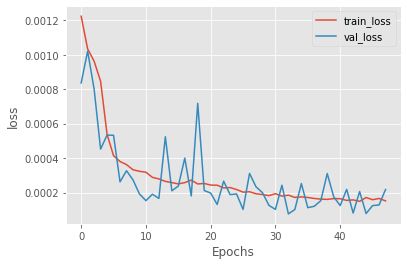

In [67]:
plt.plot(history_Full.history['last_time_step_mse'], label='train_loss')
plt.plot(history_Full.history['val_last_time_step_mse'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

In [70]:
filename='Wavenet(180_1_1)(plusepochs).h5'
callback_list2 = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_last_time_step_mse',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                                  patience=15)]

In [71]:
history_Full2= model_Full.fit(X_train_scaled, y_train_scaled, epochs=40,
                    validation_data=(X_valid_scaled,y_valid_scaled),callbacks=callback_list2)

Epoch 1/40
2041/2042 [============================>.] - ETA: 0s - loss: 1.5716e-04 - last_time_step_mse: 1.5078e-04
Epoch 00001: val_last_time_step_mse improved from inf to 0.00007, saving model to Checkpoint/Wavenet(180_1_1)(plusepochs).h5
2042/2042 [==============================] - 59s 29ms/step - loss: 1.5715e-04 - last_time_step_mse: 1.5077e-04 - val_loss: 8.3095e-05 - val_last_time_step_mse: 7.1247e-05
Epoch 2/40
2040/2042 [============================>.] - ETA: 0s - loss: 1.6123e-04 - last_time_step_mse: 1.5540e-04
Epoch 00002: val_last_time_step_mse did not improve from 0.00007
2042/2042 [==============================] - 56s 28ms/step - loss: 1.6119e-04 - last_time_step_mse: 1.5535e-04 - val_loss: 1.2714e-04 - val_last_time_step_mse: 1.1232e-04
Epoch 3/40
2042/2042 [==============================] - ETA: 0s - loss: 1.5892e-04 - last_time_step_mse: 1.5218e-04
Epoch 00003: val_last_time_step_mse did not improve from 0.00007
2042/2042 [==============================] - 57s 28ms/s

Text(0, 0.5, 'loss')

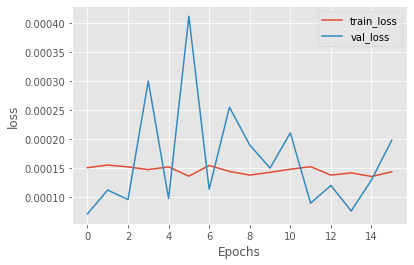

In [73]:
plt.plot(history_Full2.history['last_time_step_mse'], label='train_loss')
plt.plot(history_Full2.history['val_last_time_step_mse'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

> 첫번째 모델로 하는게 나음